In [1]:
from Utils.FS import file
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import brown
from scipy.sparse import coo_matrix, dok_matrix
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [2]:
np.random.seed(1234)

In [3]:
sents = brown.sents()
sents = [[token.lower() for token in sent] for sent in sents]
words = brown.words()
words = [word.lower() for word in words]

In [4]:
print("Number of tokens: {}".format(len(words)))
print("Number of sentences: {}".format(len(sents)))
print("Longest sentences length: {}".format(max([len(sent) for sent in sents])))

Number of tokens: 1161192
Number of sentences: 57340
Longest sentences length: 180


In [5]:
def words2dicts(words):
    f_dict = {}
    index = 0
    for word in words:
        if not word in f_dict.keys():
            f_dict[word] = index
            index = index + 1
        
    return f_dict, { v:k for k, v in f_dict.items()}

In [6]:
words_dict, inv_words_dict = words2dicts(words)
words_size = len(words_dict)
print("Number of unique tokens: {}".format(words_size))

Number of unique tokens: 49815


In [7]:
def singleSideWindow(sents, words_dict, window_size, reverse = False):
    window = []
    row = []
    col = []
    data = []
        
    for sent in reversed(sents) if reverse else sents:
        for word in reversed(sent) if reverse else sent:
            for w in window:
                if w == word:
                    continue
                row.append(words_dict[word])
                col.append(words_dict[w])
                data.append(1)
            if len(window) == window_size:
                window.pop(0)
            window.append(word)
    return coo_matrix((data, (row, col)), shape=(len(words_dict), len(words_dict)), dtype='float64')
    

def sents2wordContextMatrix(sents, words_dict, window_size = 5):
    m = coo_matrix((words_size, words_size), 'float64')
    
    print('Doing forward pass...')
    m += singleSideWindow(sents, words_dict, window_size)
    
    print('Doing backward pass...')
    m += singleSideWindow(sents, words_dict, window_size, True)
    
    return m

def sents2wordCoocurrenceMatrix(sents, words_dict, window_size = 10):
    #don't really care edge cases....

    window = []
    row = []
    col = []
    data = []
    for sent in sents:
        for word in sent:
            for i in range(len(window)- 1):
                for j in range(i+1, len(window)):
                    row += [words_dict[window[i]], words_dict[window[j]]]
                    col += [words_dict[window[j]], words_dict[window[i]]]
                    data += [1, 1]
            if len(window) == window_size:
                window.pop(0)
            window.append(word)
    print('Preparing sparse matrix...')
    print('Length of data: {}'.format(len(data)))
    return coo_matrix((data, (row,col)), shape=(words_size, words_size), dtype='float64').multiply(1/len(data))


In [8]:
def sents2ConextVector(sents, words_dict, window_size = 5):
    window = [words_dict['--'] for i in range(window_size)]
        
    for sent in sents:
        for word in sent:
            yield window, words_dict[word]
            window.pop(0)
            window.append(words_dict[word])

In [9]:
def sents2freq(sents):
    freq = {}
    for sent in sents:
        for word in sent:
            if word in freq.keys():
                freq[word] += 1
            else:
                freq[word] = 1
    return freq

words_freq = sents2freq(sents)

In [10]:
from keras.utils.np_utils import to_categorical

WINDOW_SIZE = 5
#m = sents2wordContextMatrix(sents, words_dict, WINDOW_SIZE)
generator = sents2ConextVector(sents, words_dict, 5)
X = []
y = []
for context, word in generator:
    X.append(context)
    y.append(word)

Using TensorFlow backend.


In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten
from keras.constraints import UnitNorm

DIMENSION = 50

emb = Embedding(len(words_dict), 50, input_length=WINDOW_SIZE, embeddings_constraint=UnitNorm(axis=1))
model = Sequential()
model.add(emb)
model.add(Flatten())
model.add(Dense(len(words_dict), activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 50)             2490750   
_________________________________________________________________
flatten_1 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 49815)             12503565  
Total params: 14,994,315
Trainable params: 14,994,315
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
model.compile('adam', 'sparse_categorical_crossentropy')

In [14]:
model.fit(X, y, batch_size=128, epochs=5, validation_split=0.2)

Train on 928953 samples, validate on 232239 samples
Epoch 1/5
928953/928953 [==============================] - 300s - loss: 7.1901 - val_loss: 7.1647
Epoch 2/5
928953/928953 [==============================] - 301s - loss: 7.1574 - val_loss: 7.1490
Epoch 3/5
928953/928953 [==============================] - 301s - loss: 7.1433 - val_loss: 7.1423
Epoch 4/5
928953/928953 [==============================] - 301s - loss: 7.1345 - val_loss: 7.1282
Epoch 5/5
928953/928953 [==============================] - 301s - loss: 7.1260 - val_loss: 7.1326


In [15]:
weights = emb.get_weights()
weights = weights[0]

words_vec = {}
for i in range(weights.shape[0]):
    words_vec[inv_words_dict[i]] = weights[i]

In [16]:
def plotData(vocabs, X, Y):
    plt.clf()
    plt.figure(figsize=(36, 36))
    plt.scatter(X, Y)
    plt.axis([min(X), max(X), min(Y), max(Y)])
    for label, x, y in zip(vocabs, X, Y):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()    

In [17]:
def plot(vocabs, words_vec):
    X = [words_vec[vocab][0] for vocab in vocabs]
    Y = [words_vec[vocab][1] for vocab in vocabs]
    plotData(vocabs, X, Y)

In [18]:
def plotTSNE(vocabs, vectors):
    tsne = TSNE(perplexity=30, n_components=2, n_iter=5000, random_state = 7890)
    #np.set_printoptions(suppress=True)
    data = np.array([vectors[vocab] for vocab in vocabs])    
    DATA = tsne.fit_transform(data)
    X = DATA[:, 0]
    Y = DATA[:, 1]
    
    plotData(vocabs, X, Y)

In [19]:
from DataLoader import GloVe

glove = GloVe.load2('./data/GloVe/glove.6B.50d.txt')

Start: Loading Glove Model
End: Loaded 400000 rows.


In [20]:
vocabs = ['man', 'woman', 'king', 'queen', 'male', 'female', 'boy', 'girl']
np.random.seed(1234)

random_vocabs = []
for i in np.random.randint(0, len(words_dict), 2000):
    if inv_words_dict[i] in glove.keys():
        random_vocabs.append(inv_words_dict[i])
        
print(len(random_vocabs))

1616


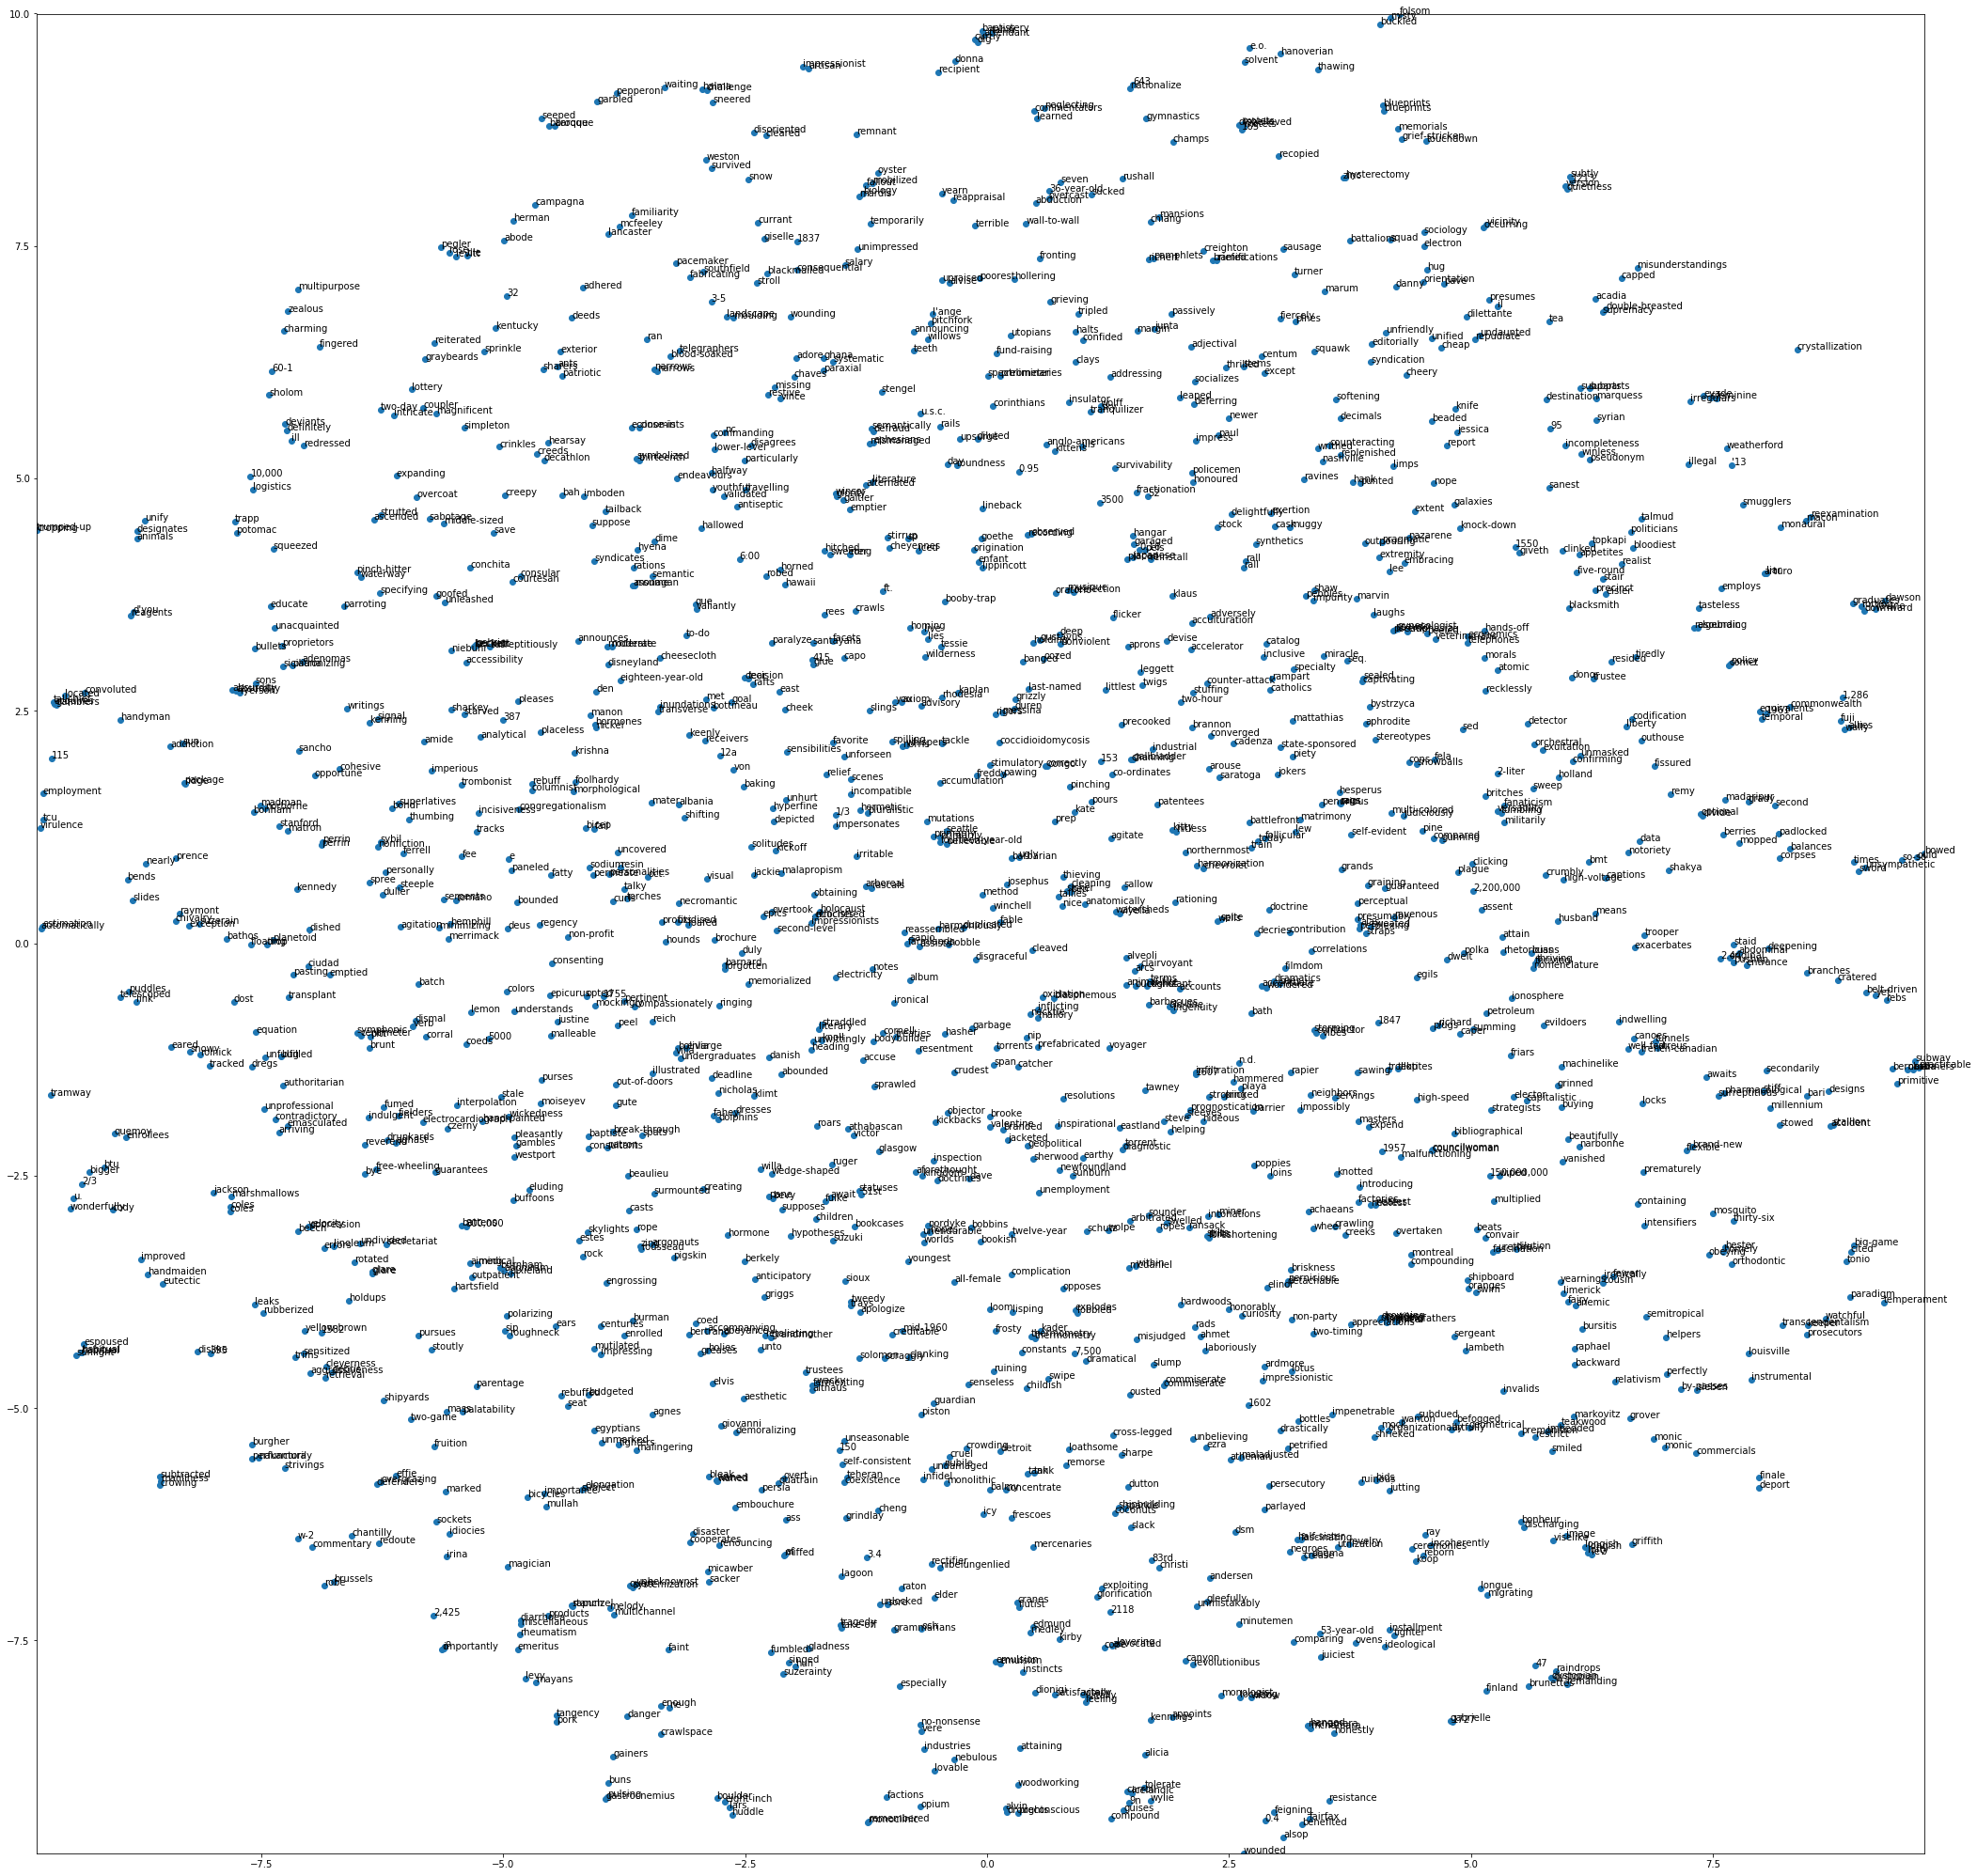

In [21]:
plotTSNE(random_vocabs, words_vec)

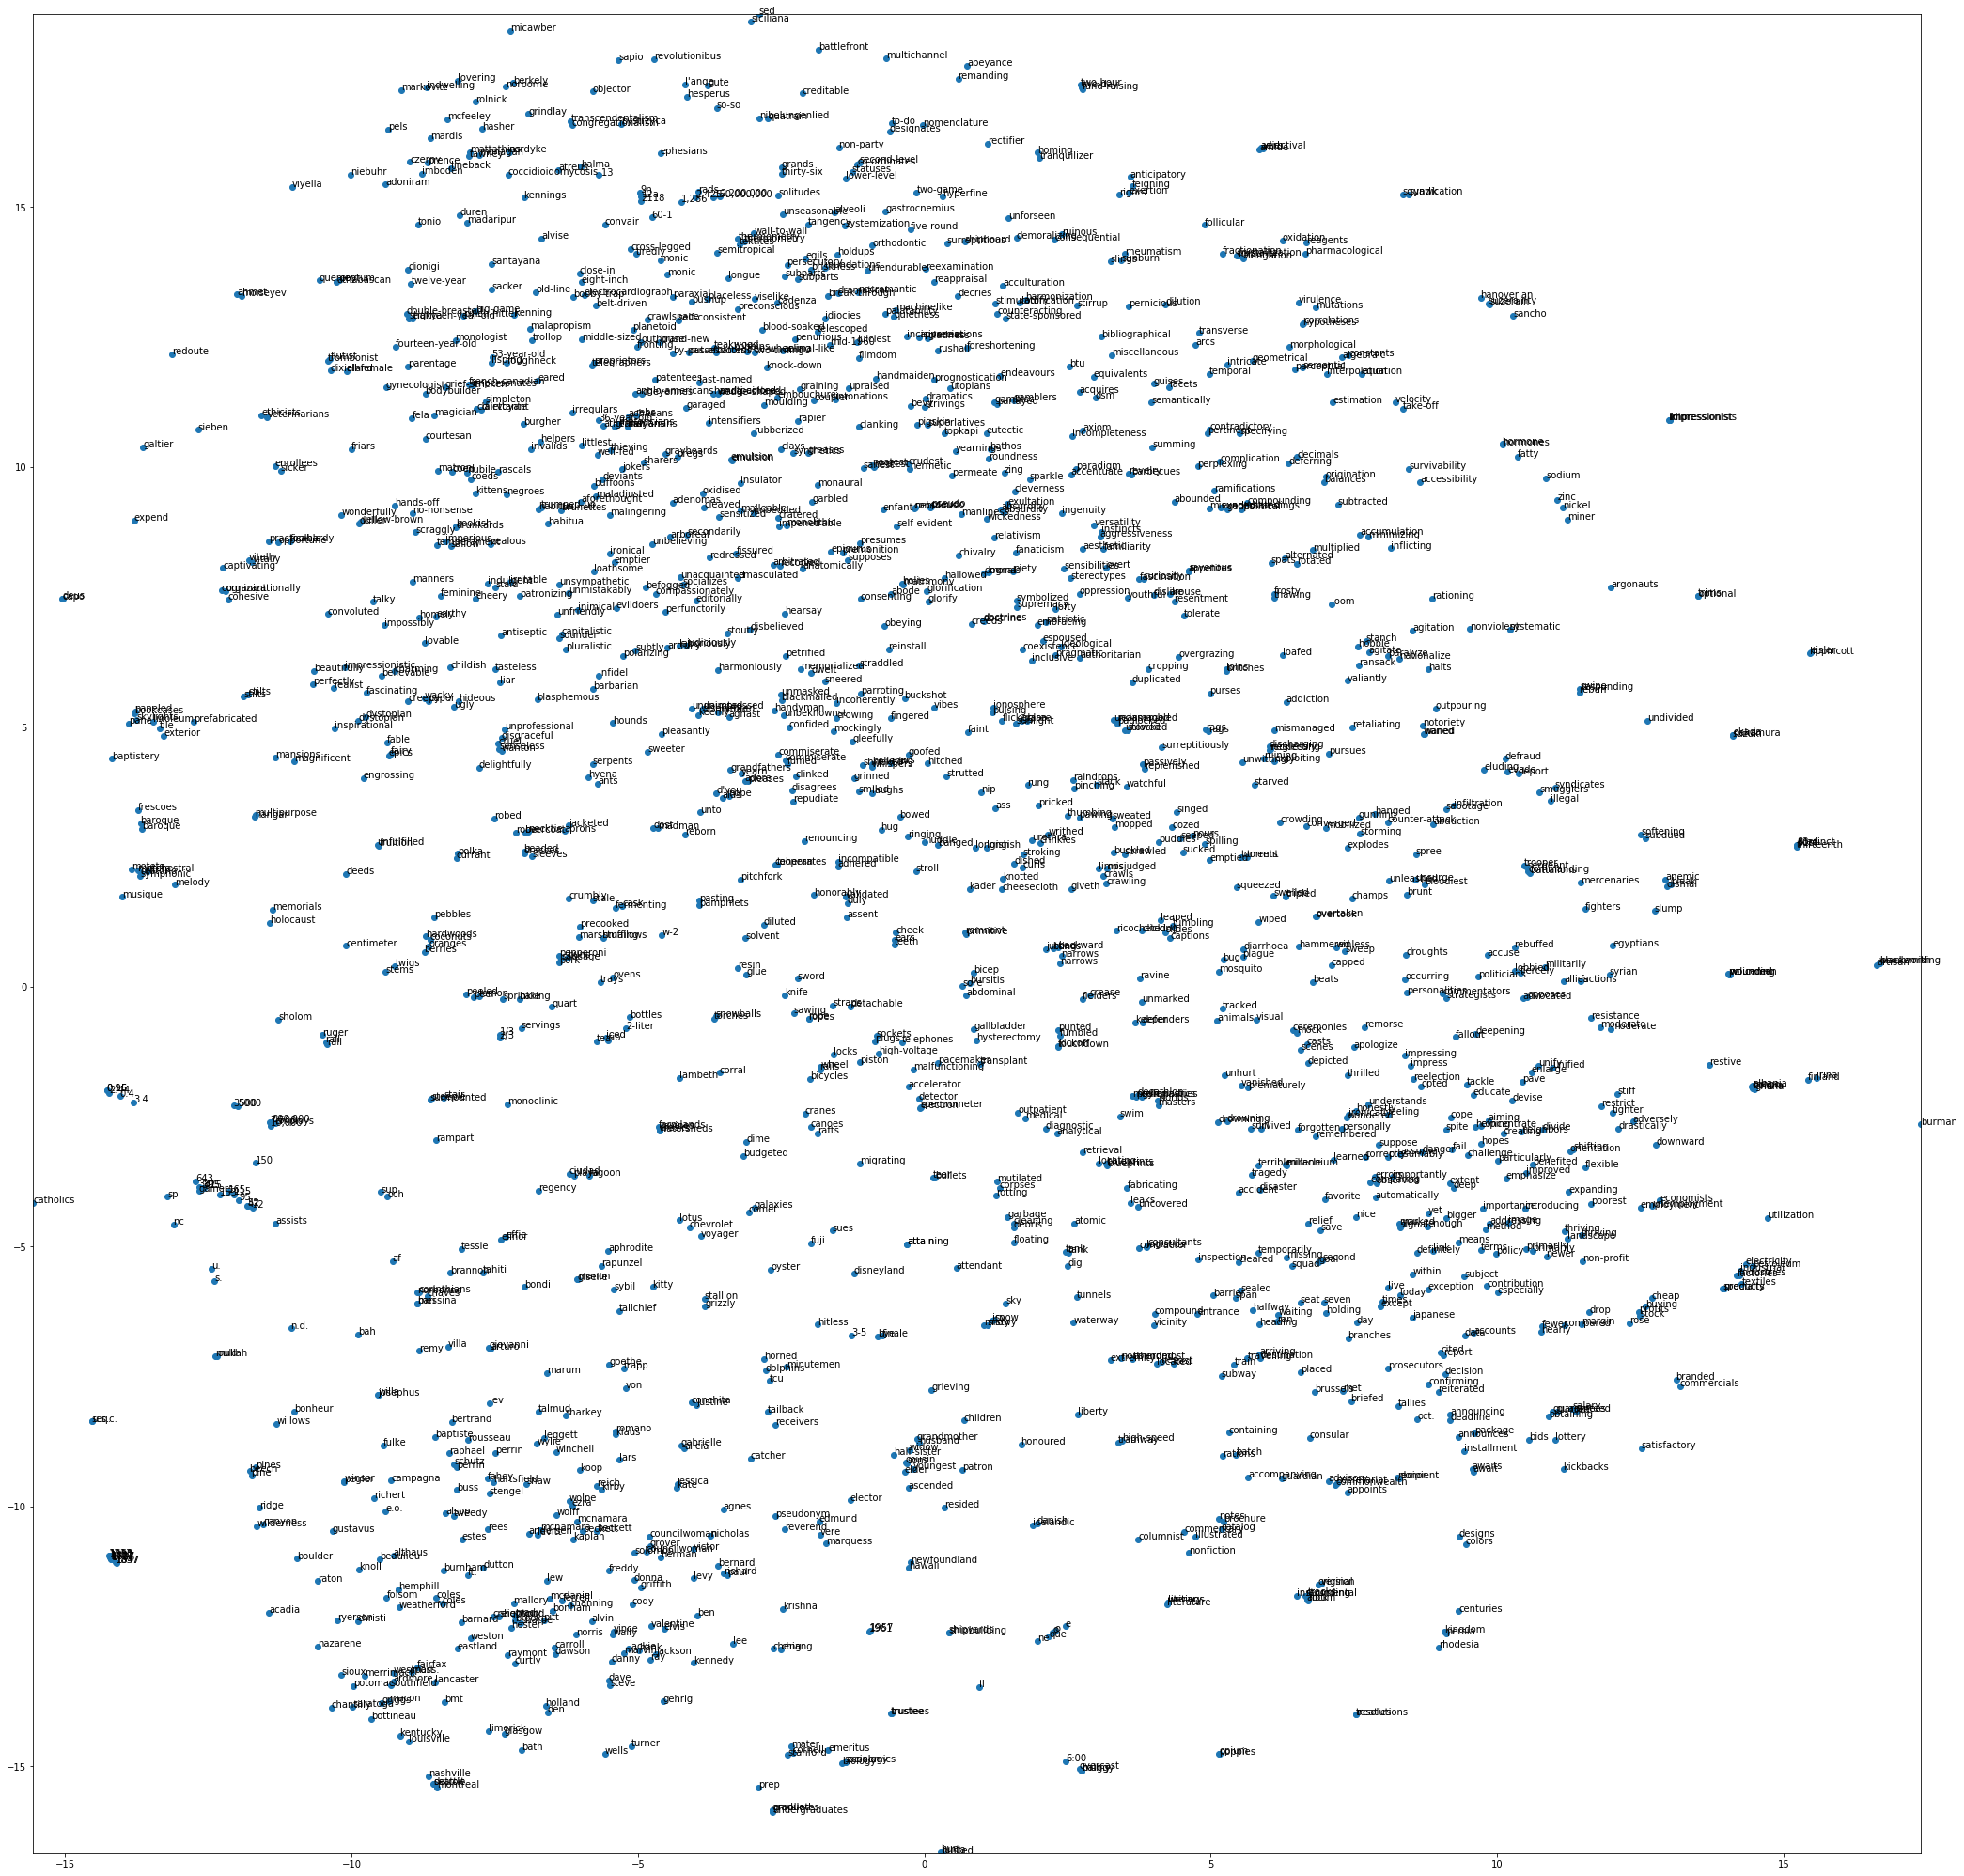

In [22]:
plotTSNE(random_vocabs, glove)

In [23]:
def cloestWord(word, words_vec, count = 10):
    dist = np.array([ sum(np.square(np.array(words_vec[word]) - np.array(words_vec[key]))) for key in words_vec.keys()])
    return [list(words_vec.keys())[i] for i in dist.argsort()[:10]]

In [24]:
print(cloestWord('man', words_vec))
print(cloestWord('man', glove))

['man', 'galindez', 'result', 'cleavage', 'hawthorne', 'counseled', 'nikolais', 'breeze', 'repair', 'self-analysis']
['man', 'woman', 'another', 'boy', 'one', 'old', 'turned', 'whose', 'himself', 'who']


In [25]:
print(cloestWord('woman', words_vec))
print(cloestWord('woman', glove))

['woman', 'relay', 'before', 'normal', 'strengthening', 'comptroller', "rev'rend", 'bsn', 'freely', 'ceased']
['woman', 'girl', 'man', 'mother', 'boy', 'her', 'she', 'herself', 'victim', 'child']


In [26]:
print(cloestWord('however', words_vec))
print(cloestWord('however', glove))

['however', 'volcanic', 'brittany', 'middle-gaelic', 'glutinous', 'revolutionists', 'contract', 'castaneda', '242%', 'nibelungenlied']
['however', 'although', 'though', 'as', 'both', 'latter', 'also', '.', 'same', 'fact']


In [27]:
print(cloestWord('his', words_vec))
print(cloestWord('his', glove))

['his', 'force-fear', 'gate', 'allied', "doolin's", 'curzon', 'ventilation', 'froth', 'versed', 'home-owners']
['his', 'he', 'himself', 'him', 'took', 'came', 'her', 'when', 'having', 'she']


In [28]:
print(cloestWord('zero', words_vec))
print(cloestWord('zero', glove))

['zero', "drawin'", 'skimming', 'nationhood', 'long-', 'non-violent', 'bloodlust', 'smells', '1596/7', 'competed']
['zero', 'mean', 'assuming', 'hence', 'actual', 'approaching', 'comparable', 'measured', 'limit', 'comparison']


In [ ]:
print(cloestWord('one', words_vec))
print(cloestWord('one', glove))

['one', 'leeway', 'sabbath', 'ambler', 'sudier', 'pinball', 'furloughed', 'little-known', 'aniseikonic', "you'd"]
['one', 'another', 'only', 'same', '.', 'as', 'well', 'but', 'with', 'making']


In [ ]:
print(cloestWord('two', words_vec))
print(cloestWord('two', glove))

['two', 'rightfield', 'lulled', 'gathering', 'ica', 'lousiness', 'waldorf-astoria', 'wishful', 'intervening', 'jointly']
